In [1]:
#kernel = .venv

import time
from time import time
t0=time()

import numpy as np
from tensorflow.keras import layers,models,callbacks,Sequential #should I remove?
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

t1=time()
print('time to load libraries=',round(t1-t0,1),'s')

time to load libraries= 4.1 s


In [2]:
t1=time()

#create synthetic data
N_train=7500000
N_test =2500000

N_train=75000
N_test =25000

nx_=7 #number of attributes

x_train=np.random.rand(N_train,7) #train & test data are separately generated
y_train=np.zeros(N_train)
x_test=np.random.rand(N_test,7)
y_test=np.zeros(N_test)


#with vectorization
def myfunc(x):
    y=np.zeros(len(x))
    for i in range(7+1):
        y=y+np.power(x[:,0]*4,i)
    #a sort of step function
    y=np.where(y>=1600,1600,np.where(y>=1200,1200,np.where(y>=800,800,np.where(y>=400,400,y))))/1600
    #create multiplication & division of other columns
    y=y+x[:,1]+np.power(x[:,2],2)+x[:,3]*x[:,4]+x[:,5]/(1+x[:,6])
    return y

#vfunc = np.vectorize(myfunc) #it actually hurts the performance

y_train=myfunc(x_train)
y_test=myfunc(x_test)

ymax=max(y_train)

y_train=y_train/ymax #a very simple normalization
y_test=y_test/ymax

t2=time(); print('time to generate synthetic data=',round(t2-t1,1),'s'); t1=t2 

time to generate synthetic data= 0.1 s


In [3]:
###############tensorflow fully connected (dense) regression
if 'model' in globals():
    del model

epoch_=50;
batch_size_=5000 #bigger batch sizes are not good

wid_=18;		dep_=28;		activation_='relu';			#MSE*1e4= 0.782 , time= 18:30

model = Sequential()
model.add(Dense(wid_, activation=activation_, kernel_initializer='he_normal', input_shape=(nx_,)))
for i in range(dep_-1):
    model.add(Dense(wid_, activation=activation_, kernel_initializer='he_normal'))
model.add(Dense(1)) #linear activation function

model.compile(optimizer='adam', loss='mse', metrics=['mse']) # compile the model

In [4]:
t1=time()

# fit the model
model.fit(x_train, y_train, epochs=epoch_, batch_size=batch_size_, verbose=2, validation_split=0.1,
          callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=2, mode='auto')])

t2=time(); tt=t2-t1; tminute=tt//60; tsec=tt-tminute*60; print('\r\ntime to train= ',int(tminute),':',int(tsec),sep=''); t1=t2

Epoch 1/50
14/14 - 1s - loss: 0.1679 - mse: 0.1679 - val_loss: 0.0968 - val_mse: 0.0968
Epoch 2/50
14/14 - 0s - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 3/50
14/14 - 0s - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 4/50
14/14 - 0s - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 5/50
14/14 - 0s - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 6/50
14/14 - 0s - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 7/50
14/14 - 0s - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 8/50
14/14 - 0s - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 9/50
14/14 - 0s - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 10/50
14/14 - 0s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 11/50
14/14 - 0s - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 12/50
14/14 - 0s - loss:

In [5]:
t1=time()

# evaluate the model
error = model.evaluate(x_train, y_train, verbose=1, batch_size=min(1000000,len(x_train)))

# make a prediction
y_test_hat = model.predict(x_test, batch_size=min(1000000,len(x_train)))

mse = mean_squared_error(y_test,y_test_hat)
print('#MSE * 1e4 = ', round(mse*1e4,3))

t2=time(); print('\r\ntime for prediction (inference)=',round(t2-t1,1),'s'); t1=t2

1/1 [==============================] - 0s 1000us/step - loss: 0.0013 - mse: 0.0013
#MSE * 1e4 =  13.495

time for prediction (inference)= 0.7 s


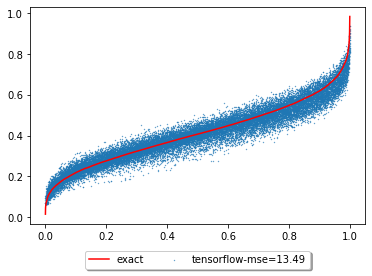

In [6]:
#plotting the results
ind_test=np.argsort(y_test)

plt.plot(np.arange(len(y_test))/len(y_test),y_test[ind_test], label='exact',zorder=2,color='red')

plt.scatter(np.arange(len(y_test))/len(y_test),y_test_hat[ind_test], 
            label='tensorflow-mse='+str(round(mse*1e4,2)),marker='o',s=0.1,zorder=1)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=5)

In [7]:
#calculate outputs using
temp_=x_test
for i in range(dep_+1):
    temp_=np.matmul(temp_,model.layers[i].get_weights()[0])+model.layers[i].get_weights()[1]
    if i<dep_: #output layer has identity activation function
        temp_[temp_<0] =0 #fancy index implementation of RelU function 

print(max(abs(y_test_hat-temp_))) #difference between outputs calculated by keras & matmul

[8.9268523e-07]
